# In the US from 1999 to 2015, were legal teams featuring greater proportions of female lawyers more or less likely to forum shop in patent law cases? 

## 1. Introduction

In the US, patent litigation has become increasingly concentrated in particular district courts (Alan C. Marco et al., 2017). One explanation for this phenomenon is increased forum shopping: filing cases in particularly favourable courts (Yan Leychkis & Leychkis, 2007). Forum shopping challenges fairness, may encourage spurious patent litigation or increase the time and effort associated with litigation (Atkinson et al., 2009),  and is often practiced among non-practicing entities: companies that buy up patents to claim fees or launch spurious litigation (Cohen et al., 2019). Forum shopping, which can require attorneys to travel to courts in other states or regions (Atkinson et al., 2009), could also increase barriers for women (Tu et al., 2022). Women make up only 25% of pharmaceutical patent prosecutors working for top law firms in the US and often report interpersonal discrimination — particularly if they have children (Tu et al., 2022). Due to gendered expectations, women generally shoulder the brunt of home labour and tend to travel less for work (Jeong et al., 2013). 

My research question examines whether legal teams’ tendencies to forum shop when filing patent cases varied depending on their gender make-up. My primary dataset consists of patent litigation data compiled by the Office of the Chief Economist of the US Patent and Trademark Office. The full dataset includes case-level data describing patent cases filed in the 94 US district courts 1963–2015; attorney-level data; and document-level data.  I focus on the post-1999 data because previous years are incomplete (Alan C. Marco et al., 2017). My secondary dataset is the World Gender Name Dictionary (WGND) 2.0, which tracks the genders associated with first names across multiple countries (Raffo, 2023).

Overall, I find that women are highly underrepresented among patent attorneys in the 94 court districts and tend to work on larger cases with bigger attorney teams and more court filings. I find that patent filings became increasingly concentrated in particular district courts from 1999–2015, which could indicate more forum shopping. Finally, I show a small positive association between the size of a patent venue and the proportion of women plaintiff attorneys, refuting my initial hypothesis.

### Choice of variables
My outcome is the level of forum shopping. Although I cannot directly observe the districts where plaintiffs and defendants primarily operate, I operationalize this based on the proportion of all patent cases in a given year filed in each of the 94 court districts. In the majority of patent infringement cases, the plaintiff determines the venue and can  decide whether to forum shop (Atkinson et al., 2009, p. 422). To determine how often women attorneys forum shop, I define my key explanatory variable as the proportion of attorneys for the plaintiff who are women. 

As additional variables, I include: year in which a case was filed, since filing rates, innovation, and gender awareness in the field vary across time; the number of lawyers involved in each case, which could reflect involvement from larger firms; and the number of documents filed, which proxies trial length and cost. I define variables indicating the proportion of defendant attorneys who are women and men, respectively, and the proportion of other (non-plaintiff and non-defendant) attorneys involved who are women and men, respectively. I also include the total number of attorneys in each category (plaintiff, defendant, and other) because the WGND did not include all first names in the attorney dataset. I include a binary variable indicating whether a case concerns patent infringement, as cases not including patent infringement may operate under different rules for determining venue.


## 2. Data Cleaning/Loading

In [6]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import gc
from sklearn.linear_model import LinearRegression
import nbconvert

# packages for summary statistics
from pandas import DataFrame
from pandas import Series

# make head display all columns instead of truncting
pd.set_option('display.max_columns', None)

# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#### Cases data

In [8]:
# call cases data to jupyter notebook
cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/cases.csv")
cases = cases.sort_values("case_name", ascending=True)

# create year variable
cases["year_filed"] = cases["case_number"].str.split(":").str[1].str[:2].astype(float)
cases.loc[cases.year_filed > 17, "year_filed"] = cases["year_filed"] + 1900
cases.loc[cases.year_filed < 17, "year_filed"] = cases["year_filed"] + 2000
cases["year_filed"] = cases["year_filed"].fillna(0).astype(float)

# these observations don't have a properly formatted case number
cases = cases.drop(index=[0, 1885, 1886])

# create case order variable (indicates 1 more than the number of cases that the court received before that case in that year)
cases["case_order"] = cases["case_number"].str.split(":").str[1]
cases["case_order"] = cases["case_order"].str.split("-").str[2].astype(float)

# create variable showing the courthouse within the district that received the case
cases["courthouse"] = cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
cases["court_name"] = cases["court_name"].str.title()

# adjust these two specific values
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (Spokane)", "Eastern District Of Washington")
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (7)", "7th Court of Appeals")

# create region variable
cases.loc[cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
cases.loc[cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
cases.loc[cases.court_name.str.contains("Western"), "court_region"] = "Western"
cases.loc[cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
cases["court_region"] = cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    cases.loc[cases.court_name.str.contains(state), "court_state"] = state

# process demand variable to get rid of non-numeric values
cases["demand"] = cases["demand"].astype(str)
cases.loc[False == cases.demand.str.strip().str.isalpha(), "demand_num"] = cases["demand"]
cases["demand_num"] = cases["demand_num"].str.replace("$", "")
cases["demand_num"] = cases["demand_num"].str.replace(",", "")
cases["demand_num"] = cases["demand_num"].astype(float)

cases.loc[cases.demand.str.strip().str.isalpha(), "demand_party"] = cases["demand"]
cases["demand_party"] = cases["demand_party"].astype(str)
cases["demand_party"] = cases["demand_party"].str.replace("p", "Plaintiff")
cases.loc[cases.demand_party == "P", "demand_party"] = str("Plaintiff")
cases.loc[cases.demand_party == "y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "Y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "nan", "demand_party"] = np.nan

In [9]:
# call pacer_cases data to jupyter notebook
pacer_cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/pacer_cases.csv")
pacer_cases = pacer_cases.sort_values("case_name", ascending=True)

# prepare the pacer_cases dataset for merging

# construct year variable
pacer_cases["year_filed"] = pacer_cases["case_number"].str.split(":").str[1].str[:4]
pacer_cases.loc[False == pacer_cases["year_filed"].str.isnumeric(), "year_filed"] = pacer_cases["year_filed"].str[:2].astype(float) + 2000
pacer_cases["year_filed"] = pacer_cases["year_filed"].fillna(0).astype(int)
# NOTE: 0 indicates NaN, 56 values

# construct case order (-1 indicates the number of cases that the court received before that case in that year)
pacer_cases["case_order"] = pacer_cases["case_number"].str.split(":").str[1]
pacer_cases["case_order"] = pacer_cases["case_order"].str.split("-").str[2]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str.split(".").str[0]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str[:5]
pacer_cases["case_order"] = pacer_cases["case_order"].astype(float)

# indicates the courthouse within the district that received the case
pacer_cases["courthouse"] = pacer_cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
pacer_cases["court_name"] = pacer_cases["court_name"].str.title()
pacer_cases["court_name"] = pacer_cases["court_name"].str.split("(").str[0]

# create region variable
pacer_cases.loc[pacer_cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Western"), "court_region"] = "Western"
pacer_cases.loc[pacer_cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
pacer_cases["court_region"] = pacer_cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    pacer_cases.loc[pacer_cases.court_name.str.contains(state), "court_state"] = state
# for 76 rows, the pacer dataset doesn't have a valid case number 

In [10]:
# merge
m_cases = pd.merge(cases, pacer_cases, on=["year_filed", "case_order", "courthouse", "court_region", "court_state"], how="left")

# fill in missing values from the cases dataset using the pacer_cases dataset
m_cases["case_name_x"] = m_cases["case_name_x"].fillna(m_cases["case_name_y"])
m_cases["date_filed_x"] = m_cases["date_filed_x"].fillna(m_cases["date_filed_y"])
m_cases["date_closed_x"] = m_cases["date_closed_x"].fillna(m_cases["date_filed_y"])

# check for missing values
m_cases.isna().sum()

# group dataset by whether the year is before or after 1999
m_cases.loc[m_cases.year_filed >= 1999, "post_99"] = 1
m_cases.loc[m_cases.year_filed < 1999, "post_99"] = 0
grouped_cases = m_cases.groupby(by="post_99")

# convert dates to date format
m_cases["date_filed"] = pd.to_datetime(m_cases["date_filed_x"])
m_cases["date_closed"] = pd.to_datetime(m_cases["date_closed_x"])
m_cases["date_last_filed"] = pd.to_datetime(m_cases["date_last_filed"])

# drop superfluous variables
m_cases = m_cases.drop(columns=["date_filed_x", "date_closed_x", "case_name_y", "court_name_y", "date_closed_y", "case_number_y", 
                                "pacer_id_y", "date_filed_y"])

# make a subset of the dataset with just the cases since 1999
cases_99 = m_cases.drop(m_cases[m_cases["post_99"] != 1].index)

del [m_cases, cases, pacer_cases]
gc.collect()
m_cases = pd.DataFrame()

# create a binary variable indicating whether a case involves patent infringement
cases_99["case_cause"] = cases_99["case_cause"].str.lower()
cases_99["case_cause"] = cases_99["case_cause"].str.strip()
cases_99.loc[cases_99.case_cause.str.contains("infringement of patent", na=False), "patent_infringement"] = 1
cases_99.loc[cases_99.case_cause.str.contains("patent infringement", na=False), "patent_infringement"] = 1
cases_99["patent_infringement"] = cases_99["patent_infringement"].fillna(0)

#### Attorneys Data

In [17]:
# call data to jupyter notebook
attorneys = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys.csv")
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender_nocode.csv")

# collapse dataset so that there's only one entry per attorney per case
attorneys = attorneys.groupby(["case_row_id", "name"]).agg("first")
attorneys = attorneys.reset_index()

# create variable w first name
attorneys["first_name"] = attorneys["name"].str.split().str[0].str.lower().astype(str)

# merge with gender dataset, drop the dataset
attorneys = attorneys.merge(gender, left_on="first_name", right_on="name", how="left")
del [gender]
gc.collect()
gender = pd.DataFrame()

In [18]:
missing_attorneys = attorneys[attorneys["gender"].isna()]
missing_attorneys = missing_attorneys[missing_attorneys["name_x"].isna() == False]

# merge with dataset with gender names for US
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender-code_US_likely.csv")
missing_attorneys = missing_attorneys.merge(gender, left_on="first_name", right_on="name",how="left")
missing_attorneys.isna().sum()

# drop variables so you can concat the missing_attorneys dataset with the attorneys dataset
missing_attorneys["name_y"] = missing_attorneys["name"]
missing_attorneys["gender"] = missing_attorneys["gender_y"]
missing_attorneys = missing_attorneys.drop(["name", "gender_y", "gender_x"], axis= 1)

# drop missing values from the attorneys dataset, add back the missing_attorneys
attorneys = attorneys[attorneys["gender"].isna() == False]
attorneys = pd.concat([attorneys, missing_attorneys], axis = 0)

del [missing_attorneys, gender]
gc.collect()
missing_attorneys = pd.DataFrame()
gender = pd.DataFrame()

In [19]:
# label each attorney either defendent, plantiff, garnishee, mediator, witness, or other
list(attorneys["party_type"].unique())
attorneys["party_type"] = attorneys["party_type"].str.lower()

attorneys.loc[attorneys.party_type.str.contains("defendant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("respondent"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("counter claimant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("dft"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("plaintiff"), "plaintiff"] = 1

attorneys.loc[attorneys.defendant.isna(), "other"] = 1
attorneys.loc[attorneys.plaintiff.isna() == False, "other"] = 0

# create gendered variables for each attorney category
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "M"), "defendant_M"] = 1
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "F"), "defendant_F"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "M"), "plaintiff_M"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "F"), "plaintiff_F"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "M"), "other_M"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "F"), "other_F"] = 1

attorneys.loc[attorneys["gender"] == "M", "male"] = 1
attorneys.loc[attorneys["gender"] == "F", "female"] = 1
attorneys["total"] = 1

In [20]:
# aggregate to create one row per case
g_attorneys = attorneys.groupby("case_row_id").agg("sum")

g_attorneys = g_attorneys.fillna(0)
g_attorneys = g_attorneys.drop(g_attorneys.iloc[:, 0:9], axis=1)

# merge g_attorneys dataset
df = cases_99.merge(g_attorneys, on="case_row_id", how="left")

del [g_attorneys]
gc.collect()
g_attorneys = pd.DataFrame()

#### Documents data

In [15]:
# call data to jupyter notebook
documents = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/documents.csv", low_memory=False)

# clean
documents["number_docs"] = 1
documents = documents.drop(documents.iloc[:, 1:9], axis=1)
doc_agg = documents.groupby("case_row_id").agg("sum")

del [documents]
gc.collect()
documents = pd.DataFrame()

#### Merging

In [23]:
# merge
df = df.merge(doc_agg, on="case_row_id", how="left")
df.to_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/df_wo_attorneys.csv", index=False)

## 3. Summary Statistics Tables

### Table 1

In [572]:
# summary statistics for X variables and Y variable

df_summaries = df.drop(["date_filed", "date_closed", "date_last_filed", 'case_number_x', 'pacer_id_x', 'case_name_x', 'court_name_x', 'assigned_to', 
                        'referred_to', 'case_cause', 'jurisdictional_basis', 'demand', 'jury_demand', 'lead_case', 'related_case', 'settlement', 
                        'case_order', 'courthouse','demand_num', 'demand_party', 'court_code', "gender"], axis=1)
df_summaries = df_summaries.groupby(["court_state", "court_region", "year_filed"]).agg("sum")
df_summaries = df_summaries.reset_index()

# create variable showing proportion of case filings made in year in a given court
for year in range(1999, 2016):
    df_summaries.loc[df_summaries["year_filed"] == year, "total_filings"] = df_summaries[df_summaries["year_filed"] == year]["post_99"].sum(axis=0)

df_summaries["percent_filings"] = 100* df_summaries["post_99"] / df_summaries["total_filings"] 

# create percent female variables
df_summaries["percent_female"] = 100 * df_summaries["female"] / (df_summaries["female"] + df_summaries["male"])
df_summaries["percent_female_P"] = 100 * df_summaries["plaintiff_F"] / (df_summaries["plaintiff_F"] + df_summaries["plaintiff_M"])
df_summaries["percent_female_D"] = 100 * df_summaries["defendant_F"] / (df_summaries["defendant_F"] + df_summaries["defendant_F"])
df_summaries.loc[df_summaries["percent_female_P"].isna(), "percent_female_P"] = 0
df_summaries.loc[df_summaries["percent_female_D"].isna(), "percent_female_D"] = 0
df_summaries.loc[df_summaries["percent_female"].isna(), "percent_female"] = 0

df_summaries["average_docs"] = df_summaries["total_filings"] / df_summaries["post_99"]

df_summaries = df_summaries[["year_filed", "post_99", "patent_infringement", "percent_filings", "average_docs", "percent_female_P", "plaintiff", 
                             "percent_female_D", "defendant", "percent_female", "female", "male", "total"]]

df_summaries["year_filed"] = df_summaries["year_filed"].astype(int)

# rename to make the rows clear
df_summaries = df_summaries.rename(columns={"year_filed": "Year filed", "post_99": "Cases filed", "patent_infringement": "Patent infringement cases", 
                                            "percent_filings":"Percent of all annual filings filed in a district court", 
                                            "average_docs": "Average documents per case", "percent_female_P": "Percent of plaintiff lawyers who are women", 
                                            "plaintiff": "Plaintiff lawyers", "percent_female_D": "Percent of defense lawyers who are women", 
                                            "defendant": "Defendant lawyers", "percent_female": "Percent all lawyers who are women", 
                                            "female": "Female lawyers", "male": "Male lawyers", "total": "Total lawyers"})

np.round(df_summaries.describe()).T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Year filed,2007.00,5.00,1999.00,2015.00
Cases filed,38.00,114.00,1.00,2564.00
Patent infringement cases,32.00,110.00,0.00,2552.00
Percent of all annual filings filed in a district court,1.00,2.00,0.00,44.00
Average documents per case,775.00,1146.00,2.00,6192.00
Percent of plaintiff lawyers who are women,13.00,12.00,0.00,100.00
Plaintiff lawyers,124.00,412.00,0.00,6631.00
Percent of defense lawyers who are women,41.00,19.00,0.00,50.00
Defendant lawyers,146.00,527.00,0.00,7445.00
Percent all lawyers who are women,14.00,9.00,0.00,100.00


#### Interpretation: Table 1
This table displays the summary statistics after collapsing the dataset by court district and year. On average, 38 cases were filed in each district, but the annual number of cases filed varied dramatically, which could indicate court shopping. On average, attorneys filed 775 documents in each case, although this variable displays rightward skewed. Large cases would likely offer the lawyers involved the most financial compensation and hold particular interest when analyzing how women patent attorneys participate in the field. The majority of cases in the dataset concern patent infringement. Since plaintiffs tend to determine the court venue for these cases, the high proportion validates my focus on women plaintiff attorneys.

Across the 94 court districts, 13% of lawyers listed as arguing for plaintiffs were women, on average. Lawyers arguing for the defense were far more likely to be women than those arguing for the plaintiff, but women still made up less than half of all attorneys for the defense, on average. These results demonstrate gendered differences in the work that patent lawyers take on and an overall lack of gender parity.


### Table 2

In [575]:
# summary statistics for women and men attorneys

# crop the datasets for merging
df_small = df.drop(["date_filed", "date_closed", "date_last_filed", 'case_number_x', 'pacer_id_x', 'case_name_x', 'court_name_x', 'assigned_to', 
                        'referred_to', 'case_cause', 'jurisdictional_basis', 'demand', 'jury_demand', 'lead_case', 'related_case', 'settlement', 
                        'case_order', 'courthouse','demand_num', 'demand_party', 'court_code', 
                    "gender", 'post_99'], axis=1)

sum_attorneys = attorneys.drop(['case_number', "position", 'party_row_count', 'party_type', 'attorney_row_count', 'contactinfo', 'first_name', 'name_y',
                                'defendant_M', 'defendant_F', 'plaintiff_M', 'plaintiff_F', 'other_M', 'other_F', 'male', 'female', 'total'],axis=1)

sum_attorneys = sum_attorneys.groupby("name_x").agg({"case_row_id": "first", "gender": "first", "defendant": "sum", "plaintiff": "sum", "other": "sum"})
totals = list(sum_attorneys.groupby('gender')['name_x'].nunique())
totals = totals[1:]

In [576]:
# merge datasets
sum_attorneys = sum_attorneys.merge(df_small, on="case_row_id", how="left")

# number of other F attorneys in their team

# sum_attorneys = sum_attorneys[["gender", 'defendant_x', 'plaintiff_x', 'other_x', 'year_filed', 'court_region', 'court_state',
sum_attorneys = sum_attorneys.rename(columns={"plaintiff_x": "Plaintiff attorney listings", "defendant_x": "Defendant attorney listings", "other_x": "Other attorneys",
                                              "patent_infringement": "Proportion patent infringement cases", "female": "Average women attorneys on cases",
                                              "total": "Average number of attorneys on cases", "number_docs": "Average documents per case", 
                                              "year_filed": "Most commonly filed in year"})


stats = sum_attorneys.groupby(["gender"]).agg({"Plaintiff attorney listings": "sum", "Defendant attorney listings": "sum", "Other attorneys": "sum", 
                                               "Proportion patent infringement cases": "mean", "Average women attorneys on cases": "mean", 
                                              "Average number of attorneys on cases": "mean", "Average documents per case": "mean", 
                                               "Most commonly filed in year": lambda x: x.value_counts().index[0]})

stats = stats.round({"Most commonly filed in year":0})
stats = stats.transpose()
stats = stats[["F", "M"]]
stats = stats.rename(columns={"F":"Women", "M": "Men"})

stats
# stats = stats.append(pd.Series([totals[1], totals[2]], index=['Women', "Men"]), ignore_index=True) 
stats.loc[len(stats)] = totals
stats.rename(index={8: "Total unique attorneys"},inplace=True)
stats

gender,Women,Men
Plaintiff attorney listings,30553.00,187352.00
Defendant attorney listings,41832.00,208933.00
Other attorneys,1296.00,8561.00
Proportion patent infringement cases,0.91,0.90
Average women attorneys on cases,4.31,2.87
Average number of attorneys on cases,19.80,18.48
Average documents per case,202.49,176.74
Most commonly filed in year,2013.00,2012.00
Total unique attorneys,20485.00,85227.00


#### Interpretation: Table 2
From 1999-2015, women were listed 30553 times as attorneys for the plaintiff in patent cases — far less than the 187352 listings for men. Women worked on teams that included more other women, on average, compared to their male counterparts. The number of male attorneys is approximately four times the number of women attorneys. Women and male attorneys tended to work on similar proportions of patent infringement cases and both experienced peak filings in the early 2010s. Women attorneys were listed on cases with, on average, more document filings and involving slightly more attorneys, compared to their male counterparts. This could indicate that women attorneys tended to work on cases with bigger teams, which could impact my results if case size impacts forum shopping incentives. 

## 4. Plots, Histograms, Figures

### Figure 1: Distribution of documents filed per US patent case by attorney gender, 1999-2015

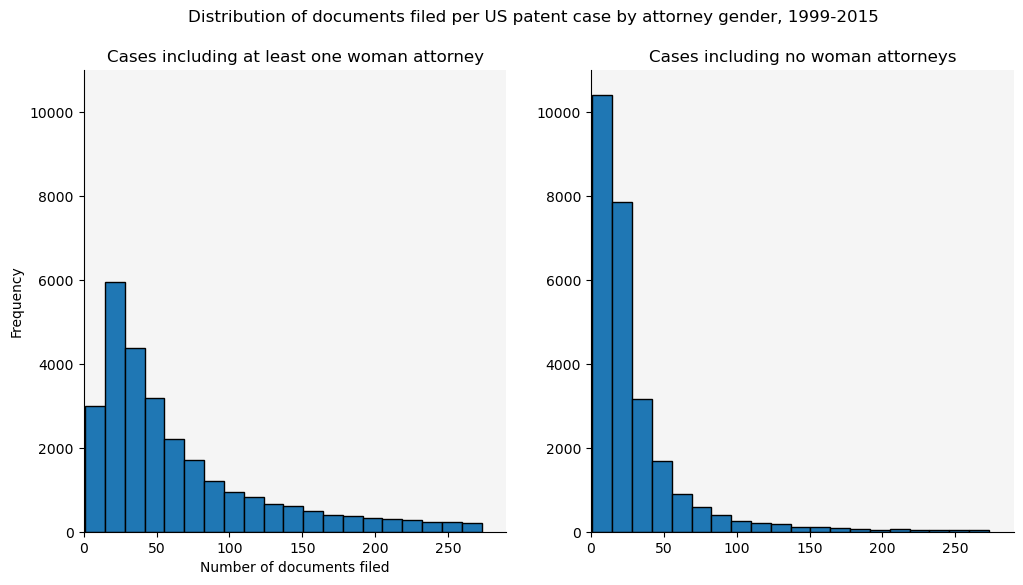

In [580]:
# histogram of the number of documents filed per case
df_hist = df[df["number_docs"] < df["number_docs"].quantile(0.95)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
df_hist[df_hist["female"] >= 1].plot(
    kind="hist", y="number_docs",
    bins=20, legend=False, ax=ax[0], edgecolor = "black"
)

df_hist[df_hist["female"] == 0].plot(
    kind="hist", y="number_docs",
    bins=20, legend=False, ax=ax[1], edgecolor = "black"
)

ax[0].set_title("Cases including at least one woman attorney")
ax[1].set_title("Cases including no woman attorneys")

ax[1].set_ylabel("")
ax[0].set_xlabel("Number of documents filed")

ax[0].set_facecolor((0.96, 0.96, 0.96))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].set_facecolor((0.96, 0.96, 0.96))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[0].set_ylim((0, 11000))
ax[0].set_xlim((0, 290))

ax[1].set_ylim((0, 11000))
ax[1].set_xlim((0, 290))

fig.suptitle("Distribution of documents filed per US patent case by attorney gender, 1999-2015")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/histogram_doc_filings.png", dpi=300, format="png")

#### Interpretation:
Regardless of the involved attorneys’ genders, the number of documents filed in each case displays heavy rightward skew. However, the skew is far more pronounced among cases that involved no woman attorneys, further demonstrating that women patent lawyers tend to work on larger cases. This could imply that women attorneys litigate fewer but larger and more lucrative cases than their male counterparts. These higher stakes could incentivize more forum shopping. 

### Figure 2: Gender make-up of patent attorneys litigating in US district courts, 1999-2015

In [583]:
### bar chart of % of lawyers who are women by party type

# collapse dataset over year ranges
df_year = df.drop(df.iloc[:, 0:14], axis=1)
df_year = df_year.drop(["date_filed",	"date_closed", "date_last_filed", "demand_num", "demand_party",'case_order', 'courthouse', 'court_code'], axis=1)
df_year.loc[df_year["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_year.loc[(2006 <= df_year["year_filed"]) & (df_year["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_year.loc[df_year["year_filed"] >= 2011, "year_range"] = "2011-2015"

df_year = df_year[['year_range', 'defendant', 'plaintiff', 'other', 'defendant_M', 'defendant_F', 'plaintiff_M', 'plaintiff_F', 'other_M', 'other_F', 'male', 
                   'female', 'total']]
df_year = df_year.groupby("year_range").agg("sum")
df_year = df_year.reset_index()

# create variables with proportion of female attorneys for each party type
df_year["percent_f"] = 100 * df_year["female"] / df_year["total"]
df_year["percent_m"] = 100 * df_year["male"] / df_year["total"]
df_year["percent_unknown"] = 100 * (df_year["total"] - df_year["female"] - df_year["male"])/ df_year["total"]

df_year["percent_pl_f"] = 100 * df_year["plaintiff_F"] / df_year["plaintiff"]
df_year["percent_pl_m"] = 100 * df_year["plaintiff_M"] / df_year["plaintiff"]
df_year["percent_pl_unknown"] = 100 * (df_year["plaintiff"] - df_year["plaintiff_M"] - df_year["plaintiff_F"])/ df_year["plaintiff"]

df_year["percent_def_f"] = 100 * df_year["defendant_F"] / df_year["defendant"]
df_year["percent_def_m"] = 100 * df_year["defendant_M"] / df_year["defendant"]
df_year["percent_def_unknown"] = 100 * (df_year["defendant"] - df_year["defendant_M"] - df_year["defendant_F"])/ df_year["defendant"]

df_year = df_year.drop(df_year.iloc[:, 1:12], axis=1)

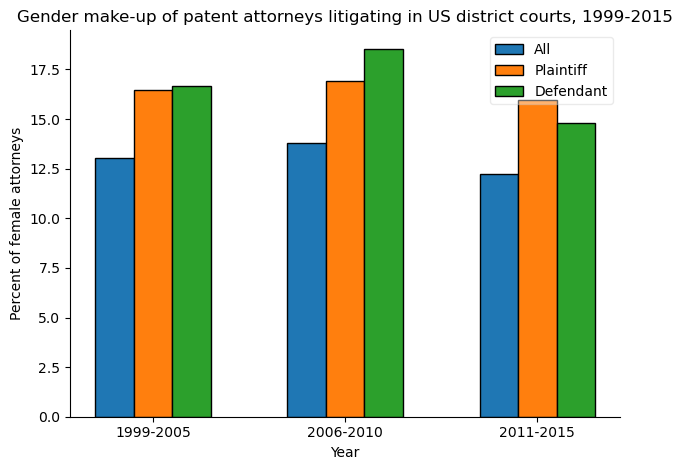

In [585]:
labels = ["All", "Plaintiff", "Defendant"]

Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list = [rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    # append the list to the final list
    Row_list.append(my_list)

range_1 = Row_list[0]
range_2 = Row_list[1]
range_3 = Row_list[2]

fig, ax = plt.subplots()

index = np.arange(3)
width = 0.2

rects1 = ax.bar(
    index, range_1, width, label='All', edgecolor="black"
)

rects2 = ax.bar(
    index + width, range_2, width, label='Plaintiff', edgecolor="black"
)

rects3 = ax.bar(
    index + width*2, range_3, width, label='Defendant', edgecolor="black"
)

ax.set_xlabel('Year')
ax.set_ylabel('Percent of female attorneys')
ax.set_title('Gender make-up of patent attorneys litigating in US district courts, 1999-2015')
ax.set_xticks(index + width )
ax.set_xticklabels(('1999-2005', '2006-2010', '2011-2015'))
ax.legend(framealpha=0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/bar_attorney_gender.png", dpi=300, format="png")

#### Interpretation:
The gender makeup of legal teams varies depending on the party for which they argued, although the patterns varied over the 16 years included in the dataset. Although defendants hired more women patent lawyers than plaintiffs from 1999 to 2010, this trend changed in 2011–2015 with a substantial drop in the proportion of women listed as attorneys for defendants. Among all groups across the three time periods, the percent of women patent attorneys listed on case filings stayed below 20%, indicating their underrepresentation. The overall proportion of women patent attorneys listed on filings decreased from 1999–2005 to 2011–2015, indicating the continued lack of progress in promoting women’s participation.

### Figure 3: US federal courts' patent filings and the gender make-up of attorneys 

In [588]:
### relationship between the proportion of court filings and the proportion of lawyers in a court who a women

df_court = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_court.loc[df_court["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_court.loc[(2006 <= df_court["year_filed"]) & (df_court["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_court.loc[df_court["year_filed"] >= 2011, "year_range"] = "2011-2015"
df_court = df_court[["court_state", "court_region", "year_range", "post_99", "plaintiff", "plaintiff_F","plaintiff_M"]]
df_court = df_court.groupby(["court_state", "court_region", "year_range"]).agg("sum")
df_court = df_court.reset_index()

# create variable showing proportion of case filings made in year range in a given court
df_court.loc[df_court["year_range"] == "1999-2005", "total_filings"] = df_court[df_court["year_range"] == "1999-2005"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2006-2010", "total_filings"] = df_court[df_court["year_range"] == "2006-2010"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2011-2015", "total_filings"] = df_court[df_court["year_range"] == "2011-2015"]["post_99"].sum(axis=0)
df_court["percent_filings"] = 100* df_court["post_99"] / df_court["total_filings"] 

df_court["percent_female"] = 100 * df_court["plaintiff_F"] / (df_court["plaintiff_F"] + df_court["plaintiff_M"])
df_court.sort_values(by=["percent_filings"])
df_court.loc[df_court["percent_female"].isna(), "percent_female"] = 0

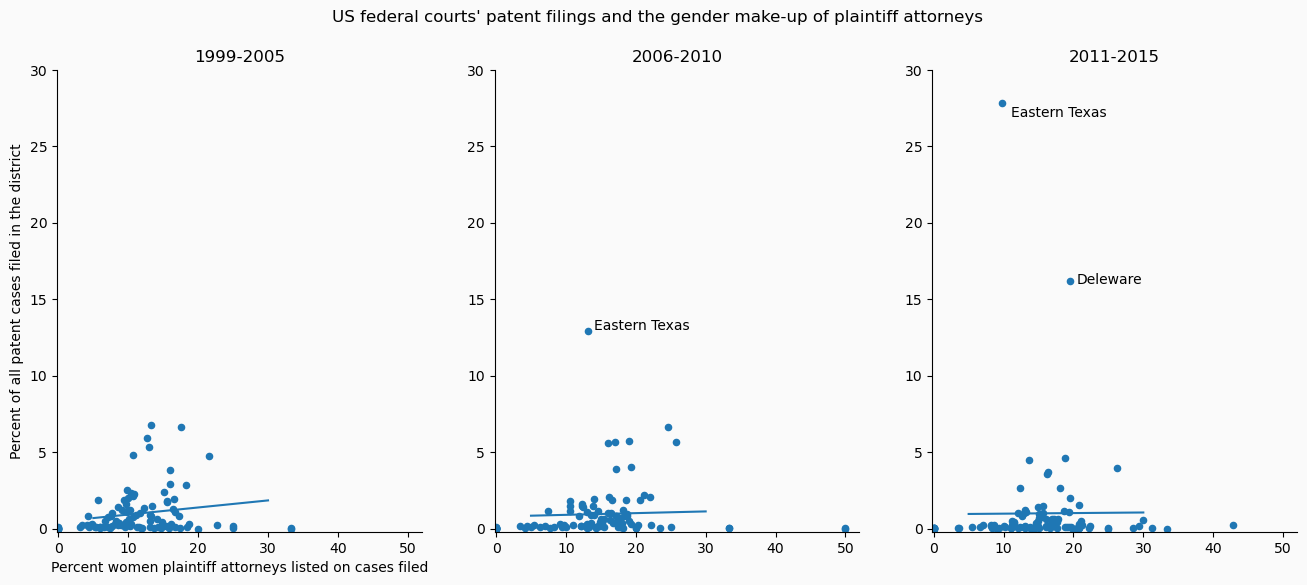

In [589]:
def single_scatter_plot(df, year, ax):
    """
    This function creates a single year's percent filings to percent female plot
    """
    # Filter data to keep only the data of interest
    _df = df_court[df_court['year_range'] == year]
    _df.plot(
        kind="scatter", x="percent_female", y="percent_filings", ax=ax
    )

    lr = LinearRegression()
    X = _df["percent_female"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
    y = _df["percent_filings"].values.reshape(-1, 1) # the output is an array
    lr.fit(X, y)

    x = np.linspace(5.0, 30.0).reshape(-1, 1)
    y_pred = lr.predict(x)
    ax.plot(x, y_pred)

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for (i, year) in enumerate(df_court.year_range.unique()):
    single_scatter_plot(df, year, ax[i])
    ax[i].set_title(str(year))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, _ax) in enumerate(ax):
    # Label with words
    if i == 0:
        _ax.set_xlabel("Percent women plaintiff attorneys listed on cases filed")
    else:
        _ax.set_xlabel("")

    # Turn off right and top axis lines
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

    # Don't use such a white background color
    _ax.set_facecolor(bgcolor)

    # Change bounds
    _ax.set_ylim((-0.2, 30))
    _ax.set_xlim((-0.2, 52))
 
    # Change ticks
    # xticks = [10, 100, 1000, 10000]
    # _ax.set_xticks([np.log(xi) for xi in xticks])
    # _ax.set_xticklabels([str(xi) for xi in xticks])

    # yticks = list(range(5, 32, 5))
    # _ax.set_yticks([np.log(yi) for yi in yticks])
    if i == 0:
        # _ax.set_yticklabels([str(yi) for yi in yticks])
        _ax.set_ylabel("Percent of all patent cases filed in the district")
    else:
        # _ax.set_yticklabels([])
        _ax.set_ylabel("")

ax[0].set_zorder(1)
ax[2].annotate("Eastern Texas", (11, 26.9), color="black")
ax[2].annotate("Deleware", (20.5, 16), color="black")
ax[1].annotate("Eastern Texas", (14, 13), color="black")
fig.suptitle("US federal courts' patent filings and the gender make-up of plaintiff attorneys")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/scatter_filings_gender.png", dpi=300, format="png")

#### Interpretation:
Across the three time periods, there appears to be a weak positive relationship between the percent of female attorneys and the percent of patent cases filed in a given district court, with the relationship weakening over time. Using the percent of patent cases filed in a given district court as a proxy for forum shopping, the results do not support my initial hypothesis. However, this fails to control for population or innovation in each district, which could explain discrepancies in case numbers. The graphs also demonstrate the rise of the Eastern District of Texas and the District of Delaware as leading patent litigation venues, with these courts together taking on more than 40% of all US district court patent filings 2011–2015. These courts are often referenced as examples of forum shopping (Yan Leychkis & Leychkis, 2007). The graphs display a wide range in the proportion of plaintiff attorneys who were women across the courts, which could reflect differences in location or the types of cases generally filed in those courts.

### Figure 4: Patent cases filed in most filed in US district circuits, 1999-2015

In [592]:
# percent filings in top 10 courts by year

df_top = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_top = df_top[["court_state", "court_region", "year_filed", "post_99"]]
df_top = df_top.groupby(["court_state", "court_region", "year_filed"]).agg("sum")
df_top = df_top.reset_index()

# create variable showing proportion of case filings made in year range in a given court
for year in range(1999, 2016):
    df_top.loc[df_top["year_filed"] == year, "total_filings"] = df_top[df_top["year_filed"] == year]["post_99"].sum(axis=0)

# create new dataset with top 10 courts, bottom 10 courts
df_top_years = df_top[df_top["year_filed"] == 1999].nlargest(10, "post_99")
for year in range(2000, 2016):
    _df = df_top[df_top["year_filed"] == year].nlargest(10, "post_99")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years["top10"] = 1

df_bottom_years = df_top[df_top["year_filed"] == 1999].nsmallest(10, "post_99")
for year in range(2000, 2016):
    _df = df_top[df_top["year_filed"] == year].nsmallest(10, "post_99")
    df_bottom_years = pd.concat([df_bottom_years, _df], axis = 0)
df_bottom_years["top10"] = 0

df_top_years["year_filed"] = df_top_years["year_filed"].astype(int)
df_top_years = df_top_years.groupby(["top10", "year_filed"]).agg({"post_99":"sum", "total_filings": "max"})

df_top_years["percent_filings"] = 100* df_top_years["post_99"] / df_top_years["total_filings"]

df_bottom_years["year_filed"] = df_bottom_years["year_filed"].astype(int)
df_bottom_years = df_bottom_years.groupby(["top10", "year_filed"]).agg({"post_99":"sum", "total_filings": "max"})

df_bottom_years["percent_filings"] = 100* df_bottom_years["post_99"] / df_bottom_years["total_filings"]

# df_top_years = df_top_years.reset_index()
# df_bottom_years = df_bottom_years.reset_index()

df_topbot = pd.concat([df_top_years, df_bottom_years], axis=0)
df_topbot = df_topbot.reset_index()

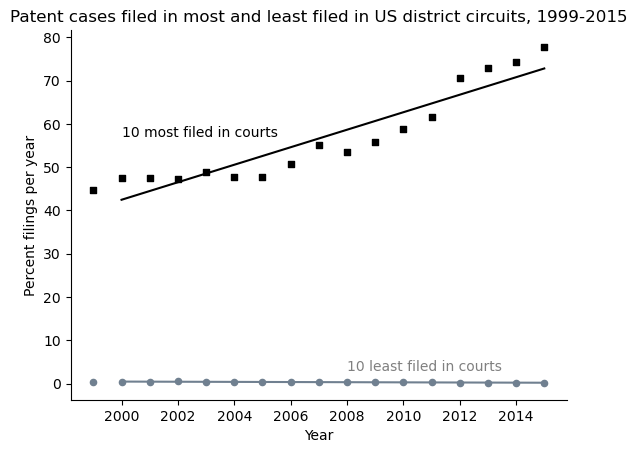

In [593]:
fig, ax = plt.subplots()

_df = df_topbot[df_topbot['top10'] == 1]
_df.plot(kind="scatter", x="year_filed", y="percent_filings", marker="s", c="black", ax=ax)

lr = LinearRegression()
X = _df["year_filed"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
y = _df["percent_filings"].values.reshape(-1, 1) # the output is an array
lr.fit(X, y)

x = np.linspace(2000, 2015).reshape(-1, 1)
y_pred = lr.predict(x)
ax.plot(x, y_pred, color="black")

_df = df_topbot[df_topbot['top10'] == 0]
_df.plot(kind="scatter", x="year_filed", y="percent_filings", marker="o", c="slategray", ax=ax)

lr = LinearRegression()
X = _df["year_filed"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
y = _df["percent_filings"].values.reshape(-1, 1) # the output is an array
lr.fit(X, y)

x = np.linspace(2000, 2015).reshape(-1, 1)
y_pred = lr.predict(x)
ax.plot(x, y_pred, color="slategray")

# ax.scatter(df_topbot.year_filed["top10" == 1], "year_filed"[z < 12], marker='s', color='b', label='z < 12')
# ax.scatter(x[z >= 12], y[z >= 12], marker='o', facecolors='none', edgecolors='r', label='z >= 12')
# ax = df_topbot.plot(x="year_filed", y="percent_filings", kind="scatter", c=color_list, marker=markers_list)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Year")
ax.set_ylabel("Percent filings per year")
ax.set_title("Patent cases filed in most and least filed in US district circuits, 1999-2015")

ax.annotate("10 most filed in courts", (2000, 57), color="black")
ax.annotate("10 least filed in courts", (2008, 3), color="gray")

plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/scatter_top10.png", dpi=200, format="png", bbox_inches="tight")

#### Interpretation:
This figure shows an increasing proportion of cases being filed in the 10 most filed in courts from 1999–2015. Although the proportion stayed relatively consistent until 2005, the proportion of cases filed in the 10 most filed in courts increased approximately 40 percentage points from 2006 to 2015, reaching almost 80%. This might demonstrate an increasing level of court shopping in that time period, which could relate to the rise of non-practicing entities. The proportion of cases filed in the least filed in courts has remained just above 0%, underscoring the discrepancies.

## 5. Conclusion
My preliminary analysis suggests a small positive association between the proportion of women attorneys for patent plaintiffs arguing in one of the 94 US federal court districts and the proportion of all patent cases filed in that court from 1999 to 2015. Although women are dramatically underrepresented in patent law, the data indicate that women plaintiff attorneys tended to argue in larger courts and primarily work on larger cases involving more documents and more attorneys. These findings suggest that the cases in which patent lawyers argue differ depending on gender and suggest that women patent lawyers may engage with more courts featuring rampant forum shopping, contradicting my initial hypothesis. Understanding these differences and what factors lead women patent attorneys to participate more in certain fields could help determine steps to address gender gaps. Additionally, I demonstrate that patent filings have become increasingly concentrated in a limited number of federal court districts. This trend could indicate forum shopping and/or increasing innovation in particular regions, with the former raising important questions about fairness and consistency in the patent legal system.

## 6. Bibliography

Alan C. Marco, Marco, A. C., Asrat Tesfayesus, Tesfayesus, A., Andrew A. Toole, Toole, A. A., & Andrew A. Toole. (2017). Patent Litigation Data from US District Court Electronic Records (1963-2015). https://doi.org/10.2139/ssrn.2942295

Atkinson, S. E., Marco, A. C., & Turner, J. L. (2009). The Economics of a Centralized Judiciary: Uniformity, Forum Shopping, and the Federal Circuit. The Journal of Law & Economics, 52(3), 411–443. https://doi.org/10.1086/597561

Jeong, Y.-J., Zvonkovic, A. M., Sano, Y., & Acock, A. C. (2013). The occurrence and frequency of overnight job travel in the USA. Work, Employment and Society, 27(1), 138–152. https://doi.org/10.1177/0950017012460328

Raffo, J. (2023). WGND 2.0 (Version 1.1) [Dataset]. Harvard Dataverse. https://doi.org/10.7910/DVN/MSEGSJ

Tu, S., Gugliuzza, P., & Semet, A. (2022). Overqualified and Underrepresented: Gender Inequality in Pharmaceutical Patent Law. BYU Law Review, 48(1), 137–196.

Yan Leychkis, & Leychkis, Y. (2007). Of Fire Ants and Claim Construction: An Empirical Study of the Meteoric Rise of the Eastern District of Texas as a Preeminent Forum for Patent Litigation. Yale Journal of Law and Technology, 9(1), 6.